**Dataset**: https://www.nature.com/articles/s41597-024-03237-9

**Encoder and Decoder Reference**: https://www.youtube.com/watch?v=U0s0f995w14

**user ID** is the unique identifier of the mobile phone user (type: integer)

**day** is the masked date of the observation. It may take a value between 0 and 74 for both Dataset 1 and Dataset 2 (type: integer).

The location pings are discretized into 500 meters × 500 meters grid cells and the timestamps are rounded up into 30-minute bins. The actual date of the observations is not available either (i.e., timeslot t of day d) to protect privacy. In the second Dataset, the 75 day period is composed of 60 days of business-as-usual and 15 days during an emergency with unusual behavior.

**timeslot** is the timestamp of the observation discretized into 30 minute intervals. 
It may take a value between 0 and 47, where 0 indicates between 0AM and 0:30AM, 
and 13 would indicate the timeslot between 6:30AM and 7:00AM.

**x,y** are the coordinates of the observed location mapped onto the 500 meter discretized grid cell. It may take a value between (1, 1) and (200, 200). Details are shown in Fig. 2.

# Import Libraries

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import random

# Load Data

In [2]:
# yjmob1 = 'yjmob100k-dataset1.csv.gz'
# yjmob2 = 'yjmob100k-dataset2.csv.gz'
# yjmob_df = pd.concat([pd.read_csv(yjmob1, compression='gzip'),
#                       pd.read_csv(yjmob2, compression='gzip')]).sort_values(by=['uid','d','t'],
#                                                                             ignore_index=True)

In [3]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # dataset under normal scenes
yjmob_df = pd.read_csv(yjmob1, compression='gzip').sort_values(by=['uid', 'd', 't'], ignore_index=True)

In [4]:
# Retrieve all ids

uids = yjmob_df['uid'].unique()

In [5]:
# Just to reduce memory space
rand_indicies = [random.randint(0, len(uids)) for _ in range(200)] # only 200 data would be used
selected_uids = [uid for uid in uids[rand_indicies]] # selected_uids = uids[:200]
# selected_uids = uids[:200]

In [7]:
df = yjmob_df[yjmob_df['uid'].isin(selected_uids)] 

# Tokenization

In [8]:
# Time
df['combined_t'] = df['d']*47+df['t']

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_74219/595267703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_t'] = df['d']*47+df['t']


In [9]:
# linearization of the 2-dimensional grid, i.e., the original x,y coordinate system
def spatial_token(x, y):
    # x,y are the coordinate location
    # x determines the column order while
    # y determines the row order
    # (x-1) calculates the starting grid-column position
    # (y-1)*200 calculates the start index of the grid-row
    return (x-1)+(y-1)*200

In [10]:
# Location
df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_74219/424670490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)


In [11]:
df = df.sort_values(by=['uid', 'combined_t'])

# Train-Test Split

In [13]:
# 7:3 split

train_uids, test_uids = train_test_split(selected_uids, test_size=0.30, random_state=42)

# 70 : (15:15) split

# test-train split
# train_val_uids, test_uids = train_test_split(selected_uids, test_size=0.15, random_state=42)

# validation-test split
# train_uids, val_uids = train_test_split(train_val_uids, test_size=0.176, random_state=42) # 0.176≈15/85

df_train = df[df['uid'].isin(train_uids)]
df_test = df[df['uid'].isin(test_uids)]

## Batching

In [30]:
BATCH_SIZE = 50

In [33]:
STEP_SIZE = 600

In [31]:
# Output input location sequence (trajectory), desired output location
# along with the time when that user reaches a location

def generate_sequences(data, data_t):
    return torch.tensor(data[:STEP_SIZE]),torch.tensor(data[STEP_SIZE]),\
                torch.tensor(data_t[:STEP_SIZE]),torch.tensor(data_t[STEP_SIZE])

In [32]:
# Group data by uid

grouped_data_train = df_train[['uid', 'combined_t', 'combined_xy']].groupby('uid')
grouped_data_train = [group for _, group in df_train.groupby('uid')]

grouped_data_test = df_test[['uid', 'combined_t', 'combined_xy']].groupby('uid')
grouped_data_test = [group for _, group in df_test.groupby('uid')]

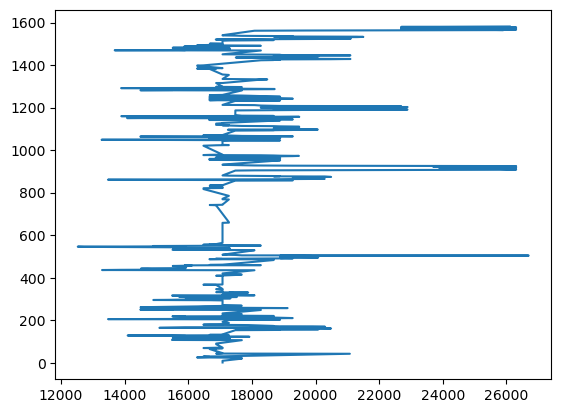

In [34]:
x = grouped_data_train[0]['combined_xy']
y = grouped_data_train[0]['combined_t']

plt.plot(x[:STEP_SIZE], y[:STEP_SIZE])

In [35]:
class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data):
        self.data = grouped_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_for_uid = self.data[idx]
        inputs, labels, positions, label_positions = generate_sequences(
                                                         data_for_uid['combined_xy'].values.tolist(),
                                                         data_for_uid['combined_t'].values.tolist())
        return inputs, labels, positions, label_positions

train_dataset = TrajectoryDataset(grouped_data_train) # train_dataset.__getitem__(0)
test_dataset = TrajectoryDataset(grouped_data_test)

In [36]:
def collate_fn(batch):
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0, batch_first=True)
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0, batch_first=True)
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [38]:
# # Example

# data_iter = iter(train_dataloader)
# inputs, labels, positions, label_positions = next(data_iter)
# print("Shape of inputs:", inputs.shape) # Shape: [batch_size, seq_len]
# print("Shape of labels:", labels.shape) # Shape: [batch_size]
# print("Shape of positions:", positions.shape) # Shape: [batch_size, seq_len]
# print("Shape of positions:", label_positions.shape) # Shape: [batch_size]

## Input Embedding and Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [39]:
EMBED_DIM = 64

In [40]:
# Time - Positional Encoding = Time Embedding + Sequential Encoding
# max_len is the maximum expected data length

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, embedding_dim):
        """
        max_len: int:
        embedding_dim: int: 
        """
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 0, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: output of the embedding layer
        """
        x = x + self.pe[:x.size(0)] # Shape [batch_size, seq_len, embed_dim]
        return x # self.dropout(x)

In [41]:
# # Example

# input_embedding_layer = nn.Embedding(40000, EMBED_DIM) # InputEmbedding(max_len, embedding_dim)
# position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
# positional_encoding = PositionalEncoding(3600, EMBED_DIM) # max_len, embedding_dim, dropout=0.1

# space_time = torch.tensor([])

# for inputs, labels, positions, label_positions in train_dataloader:
#     # Input Embedding
#     space = input_embedding_layer(inputs)
    
#     # Positional Encoding
#     positions = position_embedding_layer(positions)
#     time = positional_encoding(positions)
    
#     # Display shapes
#     print("Input Embedding:", space.shape)
#     print("Positional Encoding:", time.shape)
    
#     # Addition
#     space_time = space + time

#     break

## Self-Attention

In [42]:
NUM_HEADS = 8

In [43]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionModule, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key, value, key_padding_mask=None, need_weights=True):
        # Transpose from [batch size, seq length, embed dim] to [seq length, batch size, embed dim]
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        
        # Apply multihead attention
        attn_output, attn_output_weights = self.multihead_attn(query, key, value)
        return attn_output.transpose(0, 1)

In [44]:
# # Example

# multihead_attention = MultiHeadAttentionModule(EMBED_DIM, NUM_HEADS)
# attn_output = multihead_attention(space_time, space_time, space_time)

# print("Self Attention:", attn_output.shape)

## Transformer Block

In [45]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion):
        super(TransformerBlock, self).__init__()
        
        # Attention Layer
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        
        # Normalization 1 
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Feed-Forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim), 
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )
        
        # Normalization 2
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, query, key, value):
        attn_output = self.attention(query, key, value)
        x = self.norm1(attn_output + query)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        return out

# Encoder

In [46]:
class Encoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion
            ) for _ in range(num_layers)
        ])
        
    def forward(self, inputs, positions):
        # Input Embedding
        space = self.input_embedding(inputs)

        # Positional Encoding
        positions = self.position_embedding(positions) 
        time = self.positional_encoding(positions)
        
        # Addition
        out = space + time

        # Transformer Block = Multi-Head Attention + Norm + Feed Forward + Norm
        for layer in self.layers:
            out = layer(out, out, out)
        return out

# Decoder

In [47]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, device): 
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, forward_expansion)
        
    def forward(self, x, key, value):
        attention = self.attention(x,key,value) 
        query = self.norm(attention + x)
        out = self.transformer_block(query, key, value)
        
        return out

In [48]:
class Decoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                device=device
            ) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(embed_dim, loc_size)
        
    def forward(self, output, output_position, enc_out):
        space = self.input_embedding(output.unsqueeze(1))
        positions = self.position_embedding(output_position.unsqueeze(1))
        time = self.positional_encoding(positions)
        
        # Addition
        out = space + time

        for layer in self.layers:
            out = layer(out, enc_out, enc_out)

        out = self.fc_out(out)
        
        return out

In [49]:
# # Example

# input_embedding_layer = nn.Embedding(40000, EMBED_DIM) # InputEmbedding(max_len, embedding_dim)
# position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
# positional_encoding = PositionalEncoding(3600, EMBED_DIM) # max_len, embedding_dim

# space_time = torch.tensor([])

# for inputs, labels, positions, label_positions in train_dataloader:
#     # Input Embedding
#     space = input_embedding_layer(labels.unsqueeze(1)) # Shape: [batch_size, seq_len, embed_dim]
    
#     # Positional Encoding
#     positions = position_embedding_layer(label_positions.unsqueeze(1))
#     time = positional_encoding(positions) # Shape: [batch_size, seq_len, embed_dim]
    
#     # Display shapes
#     print("Input Embedding:", space.shape)
#     print("Positional Encoding:", time.shape)
    
#     # Addition
#     space_time = space + time

#     break

# Transformer Training Block

In [50]:
class Transformer(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion)
        self.decoder = Decoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion)
        self.device = device
    
    def forward(self, src_seq, src_pos, trg_seq, trg_pos):
        # Encode Source
        enc_out = self.encoder(src_seq, src_pos)
        
        # Decode target
        dec_out = self.decoder(trg_seq, trg_pos, enc_out)
        
        return dec_out

# Training

In [51]:
def train(model, dataloader, device, learning_rate=0.001):
    model.train()
    
    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    total_loss = 0.0
    
    for inputs, labels, positions, label_positions in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        positions = positions.to(device)
        label_positions = label_positions.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs, positions, labels, label_positions)
        
        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        total_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # print("Logits: ", outputs.detach().cpu().numpy())

    # Average loss
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss

In [52]:
def train_model(model, dataloader, device, epochs=10, learning_rate=0.001):
    for epoch in range(epochs):
        avg_loss = train(model, dataloader, device, learning_rate)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

In [53]:
EPOCH_NUM = 50

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = Transformer(loc_size=40000, 
                          time_size=3600, 
                          embed_dim=64,
                          num_layers=4, 
                          num_heads=8, 
                          device=device, 
                          forward_expansion=4)
transformer.to(device)
train_model(transformer, train_dataloader, device, epochs=EPOCH_NUM)

Epoch 1/50, Average Loss: 10.843398094177246
Epoch 2/50, Average Loss: 10.462899525960287
Epoch 3/50, Average Loss: 10.050267855326334
Epoch 4/50, Average Loss: 9.662948926289877
Epoch 5/50, Average Loss: 9.336819012959799
Epoch 6/50, Average Loss: 9.112147331237793
Epoch 7/50, Average Loss: 8.76961358388265
Epoch 8/50, Average Loss: 8.472186406453451
Epoch 9/50, Average Loss: 8.28110122680664
Epoch 10/50, Average Loss: 8.04799779256185
Epoch 11/50, Average Loss: 7.710842132568359
Epoch 12/50, Average Loss: 7.449434280395508
Epoch 13/50, Average Loss: 7.201381683349609
Epoch 14/50, Average Loss: 7.003868738810222
Epoch 15/50, Average Loss: 6.807861328125
Epoch 16/50, Average Loss: 6.570237636566162
Epoch 17/50, Average Loss: 6.29765780766805
Epoch 18/50, Average Loss: 6.123115062713623
Epoch 19/50, Average Loss: 5.897909641265869
Epoch 20/50, Average Loss: 5.700617631276448
Epoch 21/50, Average Loss: 5.4507490793863935
Epoch 22/50, Average Loss: 5.233182907104492
Epoch 23/50, Average L

# Testing

In [59]:
def inference(model, input_sequence):
    model.eval()
    with torch.no_grad():
        logits = model(input_sequence)
        probabilities = F.softmax(logits, dim=-1)
        return probabilities

In [88]:
# Example of testing where we might want to calculate the accuracy
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_examples = 0
    
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            positions = positions.to(device)
            label_positions = label_positions.to(device)
            
            logits = model(inputs, positions, labels, label_positions)
            predictions = torch.argmax(logits, dim=-1)
            
            print("Location Difference")
            print(predictions.squeeze() - labels)
            print()
            
            total_correct += (predictions.squeeze() == labels).sum().item()
            total_examples += labels.numel()
    
    accuracy = total_correct / total_examples
    return accuracy

In [89]:
test_accuracy = evaluate_model(transformer, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy}") # No Good....

Location Difference
tensor([  2586,  -8988,   4271, -13564,  12588,   -207,   8029,  -5415,  16082,
         -6938,  14459,  -3262,   -352,   8500,  17457, -16326,  -5765,  -5766,
         12675,  -3989,  17974,  14125,  11401,  -2179,   8776,  -3377,  16790,
         15294, -13109, -14126, -11979,  27119,  -4978,  26172,  -8708,    194,
          6581,  -1180,  -2798,  10856,   2603,  -2035,   4757,  13557,  -1794,
         -2649, -20251, -16133,    173, -10471])

Location Difference
tensor([ -5789,   -336,  -6227,   2017,      0,   6579,  14469,   5178,  -5992,
        -28555])

Test Accuracy: 0.016666666666666666
